<a href="https://colab.research.google.com/github/KOdunga/AIMLCourse/blob/main/NewsArticleCategorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**News Article Categorization**

## Goal
- The task is to analyze the text in news articles and build an unsupervised learning model for categorizing them. The categorization done by the model can then be validated against human-defined labels to check the overall accuracy of the AI system. The goal is to optimize the categorization process, ensuring timely and personalized delivery.

### Data Dictionary
- Text: Main body of the news articles

**Install and import the necesary libraries**

In [2]:
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

#To compute distances
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

#Import pytorch
import torch

#import the model
from sentence_transformers import SentenceTransformer

#to cluster data
from sklearn.cluster import KMeans

#to compute metrics
from sklearn.metrics import classification_report

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

**Loading the Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
reviews = pd.read_csv('/content/news_articles.csv')
reviews.head()

,Text
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n"
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the Royal Scots

In [6]:
data = reviews.copy()

## Data Overview

In [7]:
data.head()

,Text
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n"
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the Royal Scots

In [8]:
data.loc[3,'Text']

'Observers to monitor UK election\n \n Ministers will invite international observers to check the forthcoming UK general election is fairly run.\n \n The move comes amid claims the poll could be marred by electoral fraud. A report by two MPs committees called on Thursday for urgent changes to the electoral registration system to combat vote rigging and boost turnout. But in a written response to Labour MP Gordon Prentice, the government said it would normally invite observers to any UK election.\n \n Junior constitutional affairs minister Christopher Leslie said: "I fully expect us to repeat our previous practice of doing so once the date for the next general election is announced." The government has looked at ways of boosting voter turnout, which fell to 59% in the last general election in 2001.\n \n But trial all-postal ballots in four English regions last summer were hit by delays and some fraud allegations. Liberal Democrat peer Lord Greaves called last week for international obse

In [9]:
data.tail()

,Text
2220,"India opens skies to competition\n \n India will allow domestic commercial airlines to fly long haul international routes, a move it hopes will stoke competition and drive down prices.\n \n However, only state controlled carriers will be able to fly the lucrative Gulf routes, to countries such as Kuwait and Saudi Arabia, for at least three years. Jet Airways and Air Sahara are the two companies that will benefit initially. India is looking to develop its airline industry as booming economic growth drives demand for travel.\n \n Monica Chadha, BBC Delhi reporter, said air travel in India had increased by almost 20% from the previous year and was expected to rise even further. Infrastructure development is lagging demand, however, and will have to improve. ""Most international airports in the country are shabby and ill-equipped to handle heavy air traffic,"" Ms Chada said, adding that while the Civil Aviation minister has promised to modernise and privatise airports little progress has been made. Steps have been take to move things forward and the government recently changed legislation that limited foreign investment in domestic airlines. It raised the maximum stake holding allowed to 49% from 40%. Local press, meanwhile, have reported that the US and India will start negotiations about adding more routes in January. Jet Airways is India's premier private domestic carrier; Air Sahara is ranked third in the category.\n"
2221,"Yukos bankruptcy 'not US matter'\n \n Russian authorities do not have to abide by any US court decisions taken with regard to troubled oil giant Yukos, a Houston court has been told.\n \n Legal expert William Butler said there was no treaty between the US and Russia to recognise the other's legal rulings. That meant Moscow would not have to adhere to US rulings in the Yukos case. Yukos says a US court was entitled to declare it bankrupt before its Yugansk unit was sold, since it has a US subsidiary and local bank accounts.\n \n Yukos made its surprise Chapter 11 bankruptcy filing in Houston in December in an unsuccessful attempt to halt the auction of Yugansk, its main oil producing unit, by Russian authorities. Yugansk was sold to help pay off a $27.5bn (Â£14.5bn) back tax bill. It was bought for $9.4bn by a previously unknown group, which was in turn bought by state-controlled oil company Rosneft. The US court's jurisdiction has been challenged by Deutsche Bank and Gazpromneft, a former unit of Russian gas monopoly Gazprom which is due to merge with Rosneft. Deutsche Bank maintains the case has no place in a US court because Yukos has no assets in the US, apart from two bank accounts and a house in Houston owned by its chief finance officer Bruce Misamore. Deutsche Bank is involved in the case because it is itself being sued by Yukos. It had agreed to loan Gazpromneft the money to bid for Yugansk. US bankruptcy judge Letitia Clark, who issued an injunction in December to try and prevent the Yugansk sale, has said she will rule ""pretty promptly, however I do not anticipate ruling on it before next Tuesday"".\n \n Yukos has claimed it sought help in the US because other forums - Russian courts and the European Court of Human Rights - were either unfriendly or offered less protection. It has claimed that Russia imposed the huge tax bill and forced the sale of Yugansk as part of a campaign to destroy Yukos and its former owner Mihkail Khodorkovsky, who is facing a 10-year prison term in Russia for fraud and tax evasion. Yukos' parent company, the Gibraltar-based Menatep Group, is suing Russia in Europe for $28.3bn in financial damages. The company is also seeking $20bn in a separate US lawsuit against Rosneft and Gazprom for their role in the sale of Yugansk.\n"
2222,"Survey confirms property slowdown\n \n Government figures have confirmed a widely reported slowdown of the UK's housing market in late 2004.\n \n House prices were 11.8% higher on the year in the last quarter of 2004, down from 16.3

In [10]:
data.shape

(2225, 1)

**Check for missing values**

In [11]:
data.isnull().sum()

Text    0
dtype: int64

- No missing values in the dataset

**Check for duplicate values**

In [12]:
data.duplicated().sum()

98

- Has 98 duplicated entries. Drop them. Keep first is default

In [13]:
data = data.drop_duplicates()
#Reset the dataframe index
data.reset_index(drop=True, inplace=True)

In [14]:
data.duplicated().sum()

0

# Model Building

-We'll be using the **all-MiniLM-L6-v2** model here.

💡 The **all-MiniLM-L6-v2** model is an all-round (**all**) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

📊  It is a language model (**LM**) that has 6 transformer encoder layers (**L6**) and is a smaller model (**Mini**) trained to mimic the performance of a larger model (BERT).

🛠️ Potential use-cases include text classification, sentiment analysis, and semantic search.

In [15]:
#Define the model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**Encoding the dataset**

In [16]:
#setting the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
#Encoding the dataset
embedding_matrix = model.encode(data['Text'].values, device=device, show_progress_bar=True)

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

In [18]:
#Printing the sahpe of the embedding matrix
embedding_matrix.shape

(2127, 384)

- Each new article has been converted into  384 dimensional vector

In [19]:
embedding_matrix[0]

array([ 1.44794406e-02, -4.38905358e-02,  4.06048298e-02,  3.38673815e-02,
        4.66220714e-02,  5.57738310e-03, -3.69721092e-04,  1.33455191e-02,
       -1.03029281e-01, -1.23874452e-02, -5.02620116e-02, -6.02810597e-03,
       -8.61232430e-02, -3.95135172e-02,  5.19401766e-02,  4.02558744e-02,
        3.58564220e-02, -4.91258763e-02, -2.51600407e-02,  1.86599903e-02,
        4.86738011e-02,  2.63490826e-02,  2.73290556e-02,  8.51518754e-03,
       -1.01886946e-03, -3.53112854e-02, -3.98135222e-02, -2.16447692e-02,
        3.11894831e-03, -4.22789669e-03,  5.14479764e-02,  2.35553365e-02,
       -2.63928575e-03, -4.60396037e-02,  9.76820216e-02, -8.32188036e-03,
        4.85510528e-02,  2.88550276e-04, -2.75926925e-02, -6.78624511e-02,
       -8.47881020e-05, -1.21228881e-01, -1.27628654e-01,  2.30145617e-03,
        1.76545773e-02,  8.28286558e-02,  1.43665582e-01,  4.40125577e-02,
       -3.96102704e-02, -3.06835659e-02,  1.02245994e-02,  9.16654617e-02,
       -1.57279074e-02, -

## Semantic Search

In [20]:
#Define a function to compute the cosine similarity between two embedding vectors
def cosine_score(text):
  #encoding the text
  embeddings = model.encode(text)

  #Calculating the L2 norm of the embedding vector
  norm1 = np.linalg.norm(embeddings[0])
  norm2 = np.linalg.norm(embeddings[1])

  #computing the cosine similarity
  cosine_similarity_score = ((np.dot(embeddings[0], embeddings[1]))/(norm1*norm2))
  return cosine_similarity_score

**Search for similar reviews in the dataset**

In [21]:
#defining a function to find the top k similar sentences for a given query
def top_k_similar_sentences(embedding_matrix, query_text, k):
  #encoding the query text
  query_embedding = model.encode(query_text)
  #finding the cosine similarity between the query vector and all the sentences vectors
  score_vector = np.dot(embedding_matrix, query_embedding)


  #finding the top k similar sentences and sorting scores in descending order
  top_k_indices = np.argsort(score_vector)[::-1][:k]
  #returning the corresponding reviews
  return data.loc[list(top_k_indices),'Text']

In [22]:
#Defining the query text
query_text = 'Budget for elections'

#displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix, query_text, 5)

for i in top_k_reviews:
  print(i, end = '\n\n')

'Debate needed' on donations cap
 
 A cap on donations to political parties should not be introduced yet, the elections watchdog has said.
 
 Fears that big donors can buy political favours have sparked calls for a limit. In a new report, the Electoral Commission says it is worth debating a Â£10,000 cap for the future but now is not the right time to introduce it. It also says there should be more state funding for political parties and candidates should be able to spend more on election campaigning.
 
 There were almost Â£68m in reported donations to political parties in 2001, 2002 and 2003, with nearly Â£12m of them from individual gifts worth more than Â£1m. The rules have already been changed so the public can see who gives how much to the parties but the report says there are still public suspicions. The commission says capping donations would mean taxpayers giving parties more cash - something which would first have to be acceptable to the public and shown to work. "While we are 

In [23]:
#Defining the query text
query_text = 'America'

#displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix, query_text, 5)

for i in top_k_reviews:
  print(i, end = '\n\n')

US charity anthem is re-released
 
 We Are The World, the American charity anthem inspired by the success of Band Aid, has been re-issued to raise money for Aids research and tsunami victims.
 
 More than 40 stars sang as group USA For Africa, including Lionel Richie, Diana Ross, Ray Charles, Bob Dylan, Michael Jackson and Bruce Springsteen. It topped the charts in the US and UK, raising millions of dollars for African famine relief. The re-release also marks the 20th anniversary of the original recording. It has been re-issued as part of a two-disc DVD set, which will also feature footage from the recording session of the track in January 1985. The single was originally released in the US on 7 March 1985 and sold 800,000 copies in its first week. It went on to win Grammys for song of the year and record of the year.


US in EU tariff chaos trade row
 
 The US has asked the World Trade Organisation to investigate European Union customs tariffs, which it says are inconsistent and hamper

In [24]:
# defining the query text
query_text = "High imports and exports"

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix, query_text, 5)

for i in top_k_reviews:
    print(i, end="\n\n")

US trade gap ballooned in October
 
 The US trade deficit widened by more than expected in October, hitting record levels after higher oil prices raised import costs, figures have shown
 
 The trade shortfall was $55.5bn (Â£29bn), up 9% from September, the Commerce Department said. That pushed the 10 month deficit to $500.5bn. Imports rose by 3.4%, while exports increased by only 0.6%. A weaker dollar also increased the cost of imports, though this should help drive export demand in coming months. "Things are getting worse, but that's to be expected," said David Wyss of Standard & Poor's in New York. "The first thing is that when the dollar goes down, it increases the price of imports. "We are seeing improved export orders. Things seem to be going in the right direction."
 
 Despite this optimism, significant concerns remain as to how the US will fund its trade and budget deficits should they continue to widen. Another problem highlighted by analysts was the growing trade gap with Chin

## Categorization
- We will apply k-means clustering to categorize data

In [25]:
meanDistortions = []
clusters = range(2,11)

for k in clusters:
  clusterer = KMeans(n_clusters=k, random_state = 1)
  clusterer.fit(embedding_matrix)

  prediction = clusterer.predict(embedding_matrix)

  distortion = sum(
      np.min(cdist(embedding_matrix, clusterer.cluster_centers_, 'euclidean'), axis=1) ** 2)
  meanDistortions.append(distortion)

  print("Number of clusters: ", k, "\tAverage Distortion:", distortion)

Number of clusters:  2 	Average Distortion: 1794.6505503414135
Number of clusters:  3 	Average Distortion: 1721.3778811021148
Number of clusters:  4 	Average Distortion: 1666.6652249846418
Number of clusters:  5 	Average Distortion: 1621.4824284437063
Number of clusters:  6 	Average Distortion: 1591.4665176116898
Number of clusters:  7 	Average Distortion: 1568.4405361901877
Number of clusters:  8 	Average Distortion: 1547.8653544760516
Number of clusters:  9 	Average Distortion: 1533.5497729606834
Number of clusters:  10 	Average Distortion: 1515.186454230599


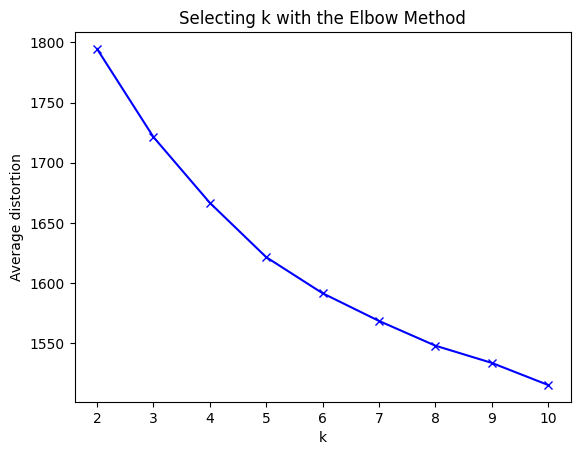

In [26]:
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show();

- The appropriate value of k from the elbow curve seems to be either 5 or 6

**We confirm or recheck using the silhoutte scores**

In [27]:
sil_score = []
cluster_list = range(2,10)

for n_clusters in cluster_list:
  clusterer = KMeans(n_clusters=n_clusters, random_state = 1)

  preds = clusterer.fit_predict(embedding_matrix)

  score = silhouette_score(embedding_matrix, preds)
  sil_score.append(score)
  print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, the silhouette score is 0.050140175968408585)
For n_clusters = 3, the silhouette score is 0.050496481359004974)
For n_clusters = 4, the silhouette score is 0.06072520092129707)
For n_clusters = 5, the silhouette score is 0.06735045462846756)
For n_clusters = 6, the silhouette score is 0.06097974628210068)
For n_clusters = 7, the silhouette score is 0.05867733433842659)
For n_clusters = 8, the silhouette score is 0.06251285970211029)
For n_clusters = 9, the silhouette score is 0.06206025555729866)


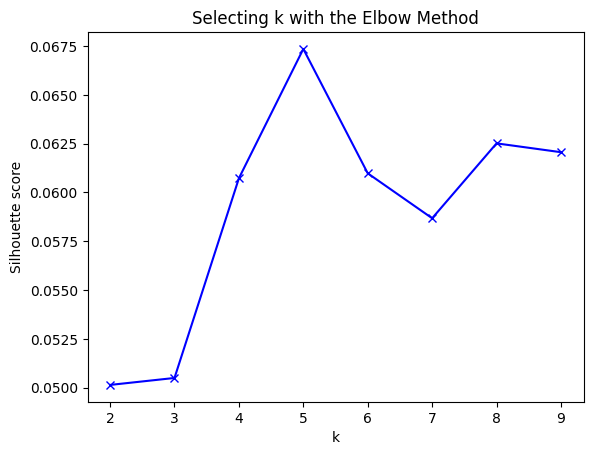

In [28]:
plt.plot(cluster_list, sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Selecting k with the Elbow Method')
plt.show();

- The silhoutte coefficient for 5 clusters is the highest.

In [29]:
#defining the number of clusters / categories
n_categories = 5

#fitting the model
kmeans = KMeans(n_clusters=n_categories, random_state = 1).fit(embedding_matrix)

In [30]:
#checking the cluster centers
centers = kmeans.cluster_centers_
centers

array([[-0.02824865, -0.03118995,  0.00693418, ..., -0.05258857,
         0.00538872,  0.03337952],
       [-0.01785408,  0.00624578, -0.00339485, ..., -0.06009006,
        -0.03252156,  0.01114385],
       [ 0.00549149, -0.02162503,  0.01707269, ..., -0.03975476,
        -0.01703277,  0.01147503],
       [-0.01044313, -0.04308654, -0.0162626 , ..., -0.06730249,
        -0.00805317,  0.00465476],
       [-0.01394477, -0.03756045,  0.00739344, ..., -0.10312268,
        -0.01400102,  0.03134283]], dtype=float32)

In [31]:
#creating a copy of the data
clustered_data = data.copy()

#assigningthe cluster/category labels
clustered_data['Category'] = kmeans.labels_

clustered_data.head()

,Text,Category
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n",2
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the 

In [32]:
#print 5 random articles from each cluster
for i in range(5):
  print(i)
  print(clustered_data.loc[clustered_data.Category == i, 'Text'].sample(5,random_state = 1).values)
  print('\n')

0
['Movie body hits peer-to-peer nets\n \n The movie industry has struck out at file-sharing networks with another round of lawsuits in the US.\n \n The Motion Picture Association of America (MPAA) also said it had succeeded in getting a network called LokiTorrent closed down. It is the latest network which uses the peer-to-peer system called BitTorrent to be hit by the MPAA. The MPAA began its legal campaign against operators of similar networks across four continents in December. A Dallas court agreed that Hollywood lawyers would be allowed access to LokiTorrent\'s server records which could let them single out those who were sharing files illegally. In October 2004, the site had provided links to more than 30,000 files. The action came after the operators of LokiTorrent agreed a settlement with the MPAA. A stark message has appeared on the site from the MPAA warning "You can click, but you can\'t hide". In BitTorrent systems, server sites do not host the files being shared. They hos

Based on the above news articles, we can see that they can be categorized as follows:

- 0: Technology
- 1: Sports
- 2: Politics
- 3: Entertainment
- 4: Business

In [33]:
#Define dicstionary to cluster label to category
category_dict = {0: 'Technology', 1: 'Sports', 2: 'Politics', 3: 'Entertainment', 4: 'Business'}

#mapping cluster  labels to category
clustered_data['Category'] = clustered_data['Category'].map(category_dict)

clustered_data.head()

,Text,Category
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n",Politics
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderer

## Compare with Actual Categories

In [35]:
labels = pd.read_csv("/content/news_article_labels.csv")
labels.shape

(2127, 1)

In [36]:
#Cehcking the unique labels
labels['Label'].unique()

array(['Politics', 'Sports', 'Technology', 'Entertainment', 'Business'],
      dtype=object)

In [37]:
#Add the actual categories to the dataframe
clustered_data['Actual Category'] = labels['Label'].values
clustered_data.head()

,Text,Category,Actual Category
0,"Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n - A freeze on petrol duty \n - An extension of tax credit scheme for poorer families \n - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in England and Wales alone, selling for less than Â£60,000. Since then, average UK property prices have more than doubled while the starting threshold for stamp duty has not increased. Tax credits As a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. The Liberal Democrats unveiled their own proposals to raise the stamp duty threshold to Â£150,000 in February.\n \n The Tories are also thought likely to propose increased thresholds, with shadow chancellor Oliver Letwin branding stamp duty a ""classic Labour stealth tax"". The Tories say whatever the chancellor gives away will be clawed back in higher taxes if Labour is returned to power. Shadow Treasury chief secretary George Osborne said: ""Everyone who looks at the British economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""If Labour is elected there will be a very substantial tax increase in the Budget after the election, of the order of around Â£10bn.""\n \n But Mr Brown's former advisor Ed Balls, now a parliamentary hopeful, said an examination of Tory plans for the economy showed there would be a Â£35bn difference in investment by the end of the next parliament between the two main parties. He added: ""I don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n \n For the Lib Dems David Laws said: ""The chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""But a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" SNP leader Alex Salmond said his party would introduce a Â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. Plaid Cymru's economics spokesman Adam Price said he wanted help to get people on the housing ladder and an increase in the minimum wage to Â£5.60 an hour.\n",Politics,Politics
1,"Army chiefs in regiments decision\n \n Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments.\n \n A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Ki

In [38]:
print(classification_report(clustered_data['Actual Category'], clustered_data['Category']))

               precision    recall  f1-score   support

     Business       0.96      0.93      0.95       503
Entertainment       0.96      0.95      0.95       369
     Politics       0.96      0.95      0.95       403
       Sports       0.98      0.99      0.99       505
   Technology       0.91      0.97      0.93       347

     accuracy                           0.96      2127
    macro avg       0.95      0.96      0.96      2127
 weighted avg       0.96      0.96      0.96      2127



- We were able to categorize the news articles with 96% accuracy

## Analyzing Incorrect Predictions
- Lets check a few cases where our model incorectly categorized the news articles

In [39]:
#creating a dataframe of incorrect categorizations
incorrect_category_data =clustered_data[clustered_data['Actual Category'] != clustered_data ['Category']].copy()
incorrect_category_data.shape

(91, 3)

In [40]:
incorrect_category_data.head()

,Text,Category,Actual Category
24,"'Hitler' row over Welsh arts cash\n \n An artist critical of Welsh arts funding being brought under assembly government control has denied comparing the idea with dictatorships in Russia and Germany.\n \n Shani Rhys James is worried that the Arts Council of Wales may be taken over by the Welsh Assembly Government. Culture Minister Alun Pugh said it would be ""crass and ignorant"" to liken a quango review to Hitler's Germany. But Ms James emphasised she had actually said artists needed freedom. The future of the Arts Council of Wales has been in question since it was announced that most Welsh quangos would eventually be abolished.\n \n It was announced last July that three Welsh quangos, education and training body Elwa, the Wales Tourist Board and the Welsh Development Agency, would be brought under assembly government control. The Arts Council of Wales may be among the next to come under the assembly government's umbrella. But Ms James, who won the Â£30,000 Jerwood painting prize in 2003, said arts funding should be separate from government. Ms James told BBC Radio Wales: ""It's quite dangerous when you involve politicians because it's not like the health service and it's not like the railways. ""Free expression is absolutely vital in a democratic society. You need distance, you do not need government interference because it could be taken the wrong way.""\n \n But she said reports that she had likened the assembly government to totalitarian regimes were inaccurate.\n \n She told Good Morning Wales: ""Just to put the record straight, that business in the paper where it said I likened the government to Bolshevik Russia or Hitler's Germany, the actual quote I gave was: 'It is vital to a civilised society that we allow artists to express themselves without government control'. ""As we know from past European history, i.e. Russia and Germany in the early 20th Century, artists will go underground or leave the country or rather than compromise their expression'. ""Artists need a free voice to express themselves - they reflect a truth through their own art forms.'"" She said the assembly government was not best placed to run the arts in Wales.\n \n She added: ""It would be a momentous change and devastating to the arts. It would set the arts scene back 60 years, because I really don't think the government has the expertise. ""If you have the National Assembly taking control, I fear you are going to be going back to the dragons and leeks and the choirs.\n \n ""Wales has moved on. It is international now. It is not set back in How Green Was My Valley?"" Responding to Ms James' criticisms, Mr Pugh said: ""The structure of unelected quangos is under review and we have made it clear that further announcements are due shortly. ""Comparing the Welsh Assembly Government to Hitler's Germany is a crass and ignorant response to a real issue about democratic accountability."" Ms James, whose father was Welsh, was born in Melbourne where her parents worked in the theatre. She moved to Powys nearly 20 years ago where she works from her studio near Llangadfan. She has won a number of arts prizes including the Wales Open in 1989 and the Mostyn Open in 1991.\n",Entertainment,Politics
34,"Final hunts held as ban looms\n \n Hunts in England and Wales have begun on the last day that hunting with dogs is legal, with more due out later.\n \n Thousands of supporters are expected to turn out at more than 250 meets, many of which have altered their normal schedules to be out on a Thursday. The ban on hunting with dogs comes into effect from 0001 GMT on Friday. The Countryside Alliance had its latest legal bid to block the ban thwarted on Wednesday when the Appeal Court ruled the Hunting Act was lawful.\n \n But the group says hunting will continue in some form after the ban comes in, with hunts expected to test the new law to its limits. Others are expected to defy the ban by continuing to hunt illegally.\n \n Anti-hunt or

In [41]:
idx = 24
print('Distance from Actual Category')
print(cdist(embedding_matrix[idx].reshape(1,-1), kmeans.cluster_centers_[[2]], 'euclidean')[0,0])

print('Distance from Predicted Category')
print(cdist(embedding_matrix[idx].reshape(1,-1), kmeans.cluster_centers_[[3]], 'euclidean')[0,0])

Distance from Actual Category
0.9629218352395096
Distance from Predicted Category
0.9545188175678067


- Distance from the actual and predicted categories is almost similar

In [43]:
idx = 45
print('Distance from Actual Category')
print(cdist(embedding_matrix[idx].reshape(1,-1), kmeans.cluster_centers_[[2]], 'euclidean')[0,0])

print('Distance from Predicted Category')
print(cdist(embedding_matrix[idx].reshape(1,-1), kmeans.cluster_centers_[[4]], 'euclidean')[0,0])

Distance from Actual Category
0.9615707378389841
Distance from Predicted Category
0.9522330349701328


## **Conclusion**

We did the following in the case study:

1. Encoded the dataset using the ***all-MiniLM-L6-v2*** transformer model to generate embeddings of 384 dimensions

2. Queried the dataset to find news articles similar to the query text we passed

3. Categorized the news articles using K-Means Clustering on the transformer encodings

4. Compared the predicted categories of the news articles to the actual categories

5. Analyzed the incorrect predictions to understand where the model went wrong

- Our model can correctly categorize 96% of the news articles.

- As mentioned, one can try tagging news articles with more than one category for better categorization.

    - One can find the cluster centers to which the news article is the closest and assign one or more categories accordingly

- Another approach that can be tried out would be fine-tuning the model to this particular data with category labels (one or more than one) to try and improve the overall performance.

- In addition, the startup can use other transformer models to generate summaries of the news articles, which can provide a gist of the news content.